In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import rdkit.Chem as Chem
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans

from descriptor_calculator import * # Module for molecular fingerprint & descriptor calculations
from training import * # Module for model training and cross validation

## Load Data

In [2]:
# Load and clean raw data
df_raw = pd.read_csv('./data/data.csv')

# Filter out rows without Max_LCAP values
df = df_raw[df_raw['Max_LCAP'].notna()]
df = df.reset_index(drop=True)
df['Round_Number'] = df['Round_Number'].apply(lambda x: int(str(x)[-1]))
df.head()

,ID_Number,Canonical_Smiles,Round_Number,Max_LCAP
0,4897720,CCCCn1ccnc1,0,0
1,18461035,CC(=O)c1ocnc1,0,72
2,1762470,Fc1ccc(cc1)c2ocnc2,0,87
3,16916940,Brc1ccc(cc1)c2cncs2,0,78
4,1040111,Fc1cc(ccc1[C@@H]2CCc3cncn23)C#N,0,0


In [3]:
# Load descriptors calculated using internal platform
mix_desc_df = pd.read_csv('./data/mix_des.csv')
mix_desc_df = mix_desc_df.dropna(axis=1)
mix_features = mix_desc_df.columns.tolist()[1:]
print(f'There are {len(mix_features)} imported MIX features from internal platform.')

# Merge the mix descriptors with the main dataframe on 'ID_Number'
df = df.merge(mix_desc_df, on='ID_Number')
df.head()

There are 3747 imported MIX features from internal platform.


,ID_Number,Canonical_Smiles,Round_Number,Max_LCAP,BrX1sp3BrX1sp305,CX1sp3BrX1sp303,CX1sp3BrX1sp304,CX1sp3BrX1sp305,CX1sp3BrX1sp306,CX1sp3BrX1sp307,...,X4sp3ClX1sp311,X4sp3NX2sp205,X4sp3NX2sp206,X4sp3NX2sp207,X4sp3NX2sp209,X4sp3NX2sp211,X4sp3NX3sp305,X4sp3OX1sp211,X4sp3OX2sp303,X4sp3SX2sp304
0,4897720,CCCCn1ccnc1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,18461035,CC(=O)c1ocnc1,0,72,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1762470,Fc1ccc(cc1)c2ocnc2,0,87,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,16916940,Brc1ccc(cc1)c2cncs2,0,78,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1040111,Fc1cc(ccc1[C@@H]2CCc3cncn23)C#N,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Load descriptors calculated from DFT-optimized geometries
df_dft = pd.read_csv('./data/data_dft.csv')

# Define DFT features
dft_features = [
    'N (eV)', 'HOMO (eV)', 'LUMO (eV)', 'Gap (eV)', 
    'Omega', 'dqG', 'Bmin', 'Bmax', 
    'L', 'PMI_X', 'PMI_Y', 'PMI_Z'
]

print(f'There are {len(dft_features)} imported DFT features.')

There are 12 imported DFT features.


In [5]:
# Calculate molecular fingerprints and descriptors
rdkit_desc = calc_rdkit_desc(df)  # Compute RDKit descriptors
rdkit_fp = calc_rdkit_fp(df, radius=2, nBits=2048)  # Compute molecular fingerprints

# Combine descriptors and fingerprints into a single dataframe
desc_fp = rdkit_desc.join(rdkit_fp)

# Optionally save combined dataframe of descriptors and fingerprints to a CSV file
#desc_fp.to_csv('./data/rdkit_desc_fp.csv', index=False)

rdkit_features = desc_fp.columns.tolist()

In [6]:
# Combine all features into a single dataframe
df_clean = pd.concat(
    [
        df[['Canonical_Smiles', 'Round_Number', 'Max_LCAP', 'ID_Number'] + mix_features], 
        desc_fp
    ], 
    axis=1
)

# Merge on 'SMILES' to include DFT features
df_clean = df_clean.merge(df_dft[dft_features + ['Canonical_Smiles']], on='Canonical_Smiles')

# Optionally save all features to a CSV file
#df_clean.to_csv('all_features.csv', index=False)

df_clean.head()

,Canonical_Smiles,Round_Number,Max_LCAP,ID_Number,BrX1sp3BrX1sp305,CX1sp3BrX1sp303,CX1sp3BrX1sp304,CX1sp3BrX1sp305,CX1sp3BrX1sp306,CX1sp3BrX1sp307,...,LUMO (eV),Gap (eV),Omega,dqG,Bmin,Bmax,L,PMI_X,PMI_Y,PMI_Z
0,CCCCn1ccnc1,0,0,4897720,0,0,0,0,0,0,...,1.55,9.23,0.018667,66.200171,1.71,7.91,5.10,15.11284,119.05900,132.05374
1,CC(=O)c1ocnc1,0,72,18461035,0,0,0,0,0,0,...,-0.79,7.93,0.052357,52.809485,1.74,4.66,7.15,17.18341,52.33765,69.00428
2,Fc1ccc(cc1)c2ocnc2,0,87,1762470,0,0,0,0,0,0,...,-0.34,7.07,0.039040,56.561304,1.65,6.65,8.40,23.60169,178.26557,201.86727
3,Brc1ccc(cc1)c2cncs2,0,78,16916940,0,0,0,0,0,0,...,-0.88,6.60,0.048713,55.462471,1.71,5.40,10.80,29.47762,386.11696,415.59459
4,Fc1cc(ccc1[C@@H]2CCc3cncn23)C#N,0,0,1040111,0,0,0,0,0,0,...,-0.95,6.63,0.050420,63.966738,1.78,7.98,5.95,87.74469,306.39359,323.60486


## Train models and calculate regression performance metrics for Round 0 and Round 7 (manuscript Table 1)

In [7]:
# Define all performance evaluation metrics and algorithm-feature combinations
metric_names = [
    'test_mae', 
    'test_rmse', 
    'test_r2_score', 
    'test_pearson_r2',
    'random_split_mae', 
    'random_split_rmse', 
    'random_split_r2_score', 
    'random_split_pearson_r2', 
    'kfold_mae', 
    'kfold_rmse', 
    'kfold_r2_score', 
    'kfold_pearson_r2'
]

feat = [
    'RF_apdp', 
    'RF_rdkit', 
    'RF_DFT', 
    'RF_rdkit_DFT', 
    'Top15_features'
]

feat_dict = {
    'RF_apdp': mix_features, 
    'RF_rdkit': rdkit_features, 
    'RF_DFT': dft_features, 
    'RF_rdkit_DFT': rdkit_features+dft_features, 
    'Top15_features': [
        'bit1233', 'bit11', 'PEOE_VSA5', 'PEOE_VSA13', 'PEOE_VSA11',
       'FpDensityMorgan2', 'PEOE_VSA3', 'bit235', 'bit1476', 'VSA_EState4',
       'VSA_EState10', 'Chi3n', 'bit1452', 'Kappa3', 'NumRotatableBonds'
    ]
}

performance_dict = {}
round_number = [0, 7]

In [8]:
# Cluster and select centroids as representative test sets
r = 7  # Specify round number
df_to_cluster = df_clean[df_clean.Round_Number <= r]

# k-means clustering
n_clusters = int(0.2 * len(df_to_cluster))  # Determine number of clusters
X = df_to_cluster[rdkit_features]  # Use RDKit features for clustering

# Initialize and fit k-means model
k_means = KMeans(n_clusters=n_clusters, init='random', n_init=10, random_state=0)
kmeans_y_pred = k_means.fit_predict(X)  # Predict cluster labels
labels = k_means.labels_  # Get cluster labels

# Create a dataframe to store SMILES and corresponding cluster labels
df_all_clusters = pd.DataFrame({'smiles': df_to_cluster.smiles,
                                 'KMeansCluster': kmeans_y_pred})

# Select ligands closest to centroid of each cluster
selected_ligands = []
for n in range(n_clusters):
    # Find all members that belong to cluster n
    members = df_all_clusters[df_all_clusters['KMeansCluster'] == n].index.tolist()
    
    # Find closest member to center of cluster n
    closest_ind = pairwise_distances_argmin_min(k_means.cluster_centers_, X.iloc[members])[0][n]
    selected_ligands.append(members[closest_ind])  # Append index of closest member to list
    
# Mark selected ligands as centroids
for i in selected_ligands:
    df_all_clusters.at[i, 'Centroid'] = 'Yes'
df_all_clusters.Centroid.fillna('No', inplace=True)
df_train = df_all_clusters[df_all_clusters.Centroid == 'No'].merge(df_clean, on='smiles')
df_test = df_all_clusters[df_all_clusters.Centroid == 'Yes'].merge(df_clean, on='smiles')

In [9]:
# Random Forest + MIX features: Comparing performance for Round 0 vs Round 7

print(f"Performance for Round {r}:")

# Initialize a list to store performance metrics for each algorithm-feature combination
metric_list = []

# Loop through each algorithm-feature combination
for a in feat:
    metrics = []
    
    # Single split k-means selected representative test performance
    model = RandomForestRegressor(random_state=0)
    _, performance, preds = model_training(
        data=df_train, 
        test_df=df_test, 
        descriptors=feat_dict[a],
        model=model
    )
    
    # Store performance metrics
    metrics += [performance['mae'], performance['rmse'], performance['r2 score'], performance['pearson r2']]
    
    
    # Cross-validation with 20 times 80:20 random split
    performance = cv_random_split_metrics(
        model=model, 
        data=df_clean[df_clean.Round_Number <= r], 
        descriptors=feat_dict[a], 
        nsplits=20, 
        metric_method='average prediction'
    )
    
    # Store additional metrics
    metrics += [performance['mae'], performance['rmse'], performance['r2 score'], performance['pearson r2']]
    
    
    # Cross-validation using 5-fold split
    performance = cv_KFold_metrics(
        model=model, 
        data=df_clean[df_clean.Round_Number <= r], 
        descriptors=feat_dict[a], 
        nsplits=5
    )
    
    metrics += [performance['mae'], performance['rmse'], performance['r2 score'], performance['pearson r2']]
    
    # Append metrics for current algorithm to metric_list
    metric_list.append(metrics)

# Create dataframe to summarize performance metrics
round_performance = pd.DataFrame(data=metric_list, columns=metric_names, index=feat)

# Optionally save performance summary to a CSV file
#round_performance.to_csv(f'./data/round_{r}_performance_summary.csv')
round_performance.head()

Performance for Round 7:
Total run time is 13.43 seconds
Total run time is 313.81 seconds
Total run time is 73.94 seconds
Total run time is 10.21 seconds
Total run time is 211.33 seconds
Total run time is 51.91 seconds
Total run time is 0.93 seconds
Total run time is 17.70 seconds
Total run time is 4.35 seconds
Total run time is 11.06 seconds
Total run time is 223.05 seconds
Total run time is 54.36 seconds
Total run time is 0.80 seconds
Total run time is 13.83 seconds
Total run time is 3.43 seconds


,test_mae,test_rmse,test_r2_score,test_pearson_r2,random_split_mae,random_split_rmse,random_split_r2_score,random_split_pearson_r2,kfold_mae,kfold_rmse,kfold_r2_score,kfold_pearson_r2
RF_apdp,9.965455,17.629008,0.721926,0.723292,7.915833,14.571661,0.785447,0.786097,9.107179,15.797770,0.647822,0.680815
RF_rdkit,11.748571,19.439721,0.661869,0.664400,8.922457,15.390483,0.760657,0.760659,9.404664,15.723730,0.651805,0.675098
RF_DFT,19.597532,25.855912,0.401830,0.402123,15.348485,22.734950,0.477718,0.477977,17.533269,24.795100,0.170339,0.307518
RF_rdkit_DFT,11.725844,19.487244,0.660214,0.662195,8.988411,15.541567,0.755934,0.755935,9.407908,15.704640,0.654908,0.675313
Top15_features,14.001169,23.160465,0.520046,0.539190,10.124287,17.375442,0.694938,0.696225,11.097800,18.395734,0.519400,0.565754


In [10]:
# Extract corelation metrics from round performance dataframe
round_r2s = round_performance[['random_split_pearson_r2', 
                               'kfold_pearson_r2', 
                               'test_pearson_r2',
                               'random_split_r2_score', 
                               'kfold_r2_score', 
                               'test_r2_score']]

round_r2s = round_r2s.transpose()
round_r2s

,RF_apdp,RF_rdkit,RF_DFT,RF_rdkit_DFT,Top15_features
random_split_pearson_r2,0.786097,0.760659,0.477977,0.755935,0.696225
kfold_pearson_r2,0.680815,0.675098,0.307518,0.675313,0.565754
test_pearson_r2,0.723292,0.664400,0.402123,0.662195,0.539190
random_split_r2_score,0.785447,0.760657,0.477718,0.755934,0.694938
kfold_r2_score,0.647822,0.651805,0.170339,0.654908,0.519400
test_r2_score,0.721926,0.661869,0.401830,0.660214,0.520046


In [11]:
# Extract error metrics from round performance dataframe
round_errors = round_performance[['random_split_mae', 
                                   'kfold_mae', 
                                   'test_mae', 
                                   'random_split_rmse', 
                                   'kfold_rmse', 
                                   'test_rmse']]

round_errors = round_errors.transpose()
round_errors

,RF_apdp,RF_rdkit,RF_DFT,RF_rdkit_DFT,Top15_features
random_split_mae,7.915833,8.922457,15.348485,8.988411,10.124287
kfold_mae,9.107179,9.404664,17.533269,9.407908,11.097800
test_mae,9.965455,11.748571,19.597532,11.725844,14.001169
random_split_rmse,14.571661,15.390483,22.734950,15.541567,17.375442
kfold_rmse,15.797770,15.723730,24.795100,15.704640,18.395734
test_rmse,17.629008,19.439721,25.855912,19.487244,23.160465


## Visualize representative test set molecules

/home/hecy/.conda/envs/CHML1/lib/python3.6/site-packages/rdkit/Chem/Draw/IPythonConsole.py:192: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


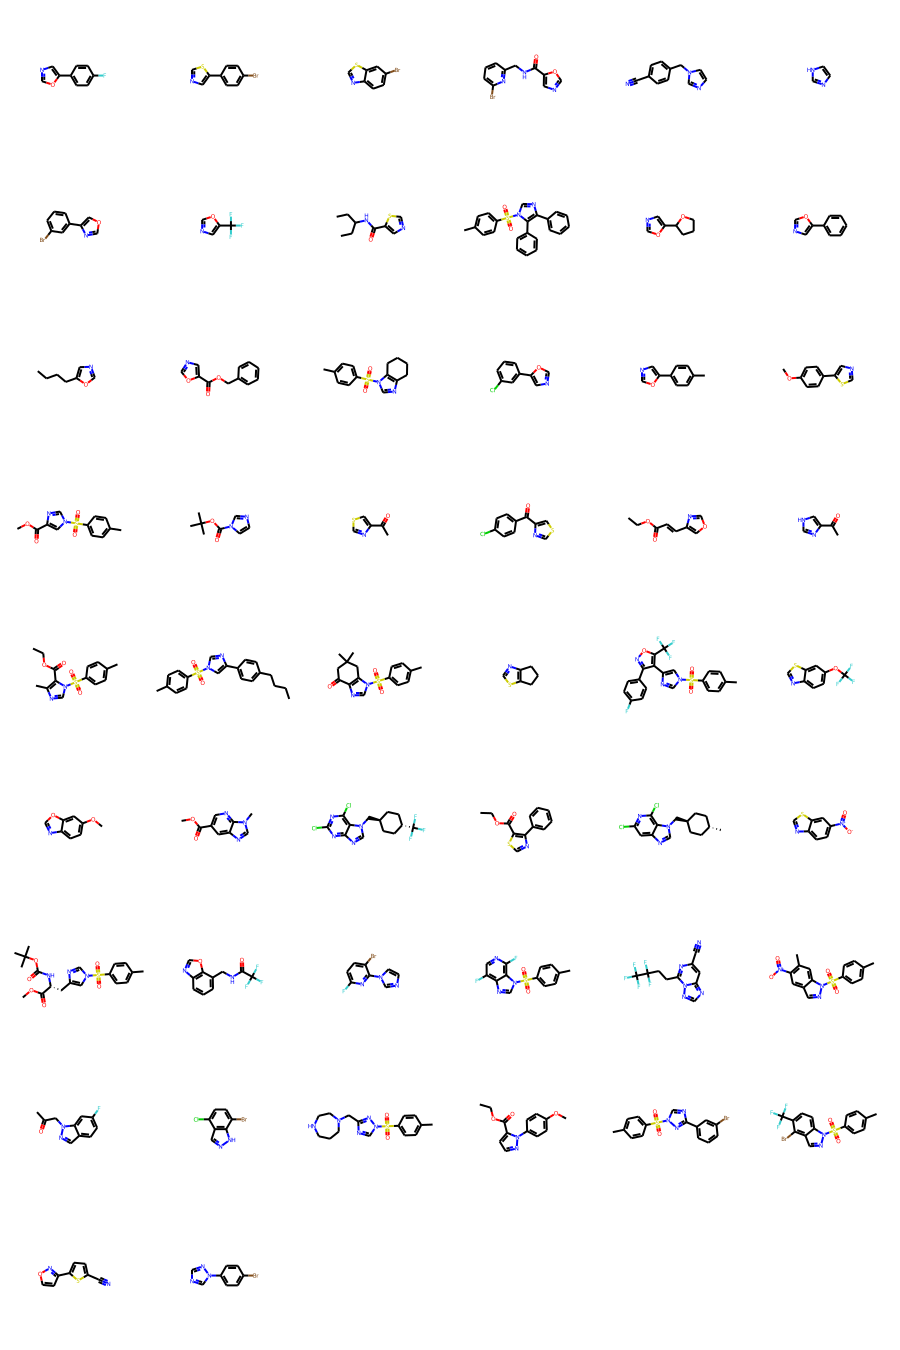

In [12]:
from rdkit.Chem import Draw
mols = [Chem.MolFromSmiles(s) for s in preds['smiles']]
Draw.MolsToGridImage(mols, molsPerRow=6, subImgSize=(150, 150))

## Compare feature combinations for Rounds 0 & 7 models (manuscript Figure 7A)

  0%|          | 0/4 [00:00<?, ?it/s]

Total run time is 8.23 seconds
Performance for Round 0 with descriptors dft: 
        Metric      Value
0  pearson r2   0.472693
1         mae  23.132000
2    r2 score  -0.254484
3        rmse  27.938883


 25%|██▌       | 1/4 [00:24<01:14, 24.76s/it]

Total run time is 16.46 seconds
Performance for Round 7 with descriptors dft: 
        Metric      Value
0  pearson r2   0.488357
1         mae  15.422885
2    r2 score   0.474685
3        rmse  22.840901
Total run time is 19.44 seconds
Performance for Round 0 with descriptors mix: 
        Metric      Value
0  pearson r2   0.222426
1         mae  28.412000
2    r2 score  -0.738608
3        rmse  33.165472


 50%|█████     | 2/4 [05:43<06:35, 197.51s/it]

Total run time is 298.89 seconds
Performance for Round 7 with descriptors mix: 
        Metric      Value
0  pearson r2   0.763960
1         mae   8.286392
2    r2 score   0.753358
3        rmse  15.638528
Total run time is 16.17 seconds
Performance for Round 0 with descriptors rdkit: 
        Metric      Value
0  pearson r2   0.416308
1         mae  22.254300
2    r2 score  -0.204633
3        rmse  27.062223


 75%|███████▌  | 3/4 [09:30<03:31, 211.34s/it]

Total run time is 211.50 seconds
Performance for Round 7 with descriptors rdkit: 
        Metric      Value
0  pearson r2   0.747447
1         mae   9.122725
2    r2 score   0.737754
3        rmse  16.117877
Total run time is 16.13 seconds
Performance for Round 0 with descriptors rdkit+dft: 
        Metric      Value
0  pearson r2   0.421913
1         mae  22.190600
2    r2 score  -0.159585
3        rmse  27.121310


100%|██████████| 4/4 [13:28<00:00, 202.17s/it]

Total run time is 221.36 seconds
Performance for Round 7 with descriptors rdkit+dft: 
        Metric      Value
0  pearson r2   0.747425
1         mae   9.208359
2    r2 score   0.737522
3        rmse  16.132664


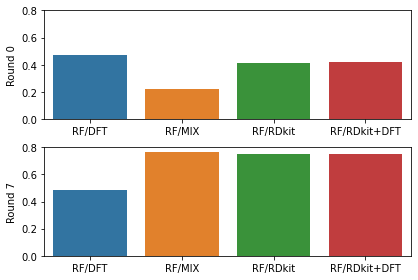

,Round 0,Round 7
RF/DFT,0.472693,0.488357
RF/MIX,0.222426,0.763960
RF/RDkit,0.416308,0.747447
RF/RDkit+DFT,0.421913,0.747425


In [13]:
# Define the descriptors
descriptors_list = [
    dft_features, 
    mix_features, 
    rdkit_features, 
    rdkit_features + dft_features
]

names = ['dft','mix','rdkit','rdkit+dft']

# Initialize lists to store results
round0_r2s = []
round07_r2s = []

# Loop over different descriptors
for i in tqdm(range(len(descriptors_list))):
    # Round 0
    descriptors = descriptors_list[i]
    performance = cv_random_split_metrics(
        model='random forest', 
        data=df_clean[df_clean.Round_Number == 0], 
        descriptors=descriptors, 
        nsplits=20, 
        metric_method='average performance', 
        test_size=0.2
    )
    round0_r2s.append(performance['pearson r2'])
    performance_df = pd.DataFrame(performance.items(), columns=['Metric', 'Value'])
    print(f'Performance for Round 0 with descriptors {names[i]}: \n', performance_df)

    # Round 7
    performance = cv_random_split_metrics(
        model='random forest', 
        data=df_clean[df_clean.Round_Number <= 7], 
        descriptors=descriptors,
        nsplits=20, 
        metric_method='average performance', 
        test_size=0.2
    )
    round07_r2s.append(performance['pearson r2'])
    performance_df = pd.DataFrame(performance.items(), columns=['Metric', 'Value'])
    print(f'Performance for Round 7 with descriptors {names[i]}: \n', performance_df)

# Create a DataFrame for R2 values
r2_df = pd.DataFrame(list(zip(round0_r2s, round07_r2s)),
                     columns=['Round 0', 'Round 7'], 
                     index=["RF/DFT", "RF/MIX", "RF/RDkit", "RF/RDkit+DFT"])

# Optional: Save to CSV
# r2_df.to_csv('./data/feature_comparisons.csv')

# Plotting
plt.figure()
plt.subplot(2, 1, 1)
sns.barplot(x=r2_df.index.tolist(), y=round0_r2s)
plt.ylabel('Round 0')
plt.ylim([0, 0.8])
plt.subplot(2, 1, 2)
sns.barplot(x=r2_df.index.tolist(), y=round07_r2s)
plt.ylabel('Round 7')
plt.tight_layout()
plt.show()

r2_df